In [1]:
import os

if not os.path.exists('NAFNet'):
    !git clone https://github.com/megvii-research/NAFNet
%cd NAFNet

Cloning into 'NAFNet'...
remote: Enumerating objects: 521, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 521 (delta 180), reused 142 (delta 142), pack-reused 296 (from 1)
Receiving objects: 100% (521/521), 16.19 MiB | 28.53 MiB/s, done.
Resolving deltas: 100% (277/277), done.
/content/NAFNet


In [2]:
!pip install -r requirements.txt
!pip install --upgrade --no-cache-dir gdown
!python3 setup.py develop --no_cuda_ext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 24.2 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        

In [3]:
import gdown
gdown.download('https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR', "./experiments/pretrained_models/", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR
From (redirected): https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR&confirm=t&uuid=66ea6b3e-db79-458c-8f15-a4d32ce09585
To: /content/NAFNet/experiments/pretrained_models/NAFNet-SIDD-width64.pth
100%|██████████| 464M/464M [00:12<00:00, 35.9MB/s]


'./experiments/pretrained_models/NAFNet-SIDD-width64.pth'

In [5]:
import shutil
from google.colab import drive
drive.mount('/content/drive')

# Dataset pour les images bruitées sel et poivre
if not os.path.exists('/content/noisy'):
    source_path = '/content/drive/My Drive/noisy'
    destination_path = '/content/noisy'
    shutil.copytree(source_path, destination_path)
    print(f"Le dossier 'noisy' a été copié dans {destination_path}")

# Dataset pour les images bruitées sel et poivre
if not os.path.exists('/content/gt'):
    source_path = '/content/drive/My Drive/gt_1'
    destination_path = '/content/gt_v1'
    shutil.copytree(source_path, destination_path)
    print(f"Le dossier 'gt_v1' a été copié dans {destination_path}")

# Dossier où va être stocker les images débruités de nafnet sel et poivre
if not os.path.exists('/content/denoisy/nafnet/salt_pepper'):
    os.makedirs('/content/denoisy/nafnet/salt_pepper')
    print(f"Le dossier 'denoisy/nafnet/salt_pepper' a été créé")

# Dossier où va être stocker les images débruités de nafnet sel et poivre
if not os.path.exists('/content/denoisy/nafnet/gaussian'):
    os.makedirs('/content/denoisy/nafnet/gaussian')
    print(f"Le dossier 'denoisy/nafnet/gaussian' a été créé")

Mounted at /content/drive
Le dossier 'noisy' a été copié dans /content/noisy
Le dossier 'gt_v1' a été copié dans /content/gt_v1
Le dossier 'denoisy/nafnet/salt_pepper' a été créé
Le dossier 'denoisy/nafnet/gaussian' a été créé


In [6]:
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('NAFNet output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)

def single_image_inference(model, img, save_path):
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      sr_img = tensor2img([visuals['result']])
      imwrite(sr_img, save_path)

In [7]:
opt_path = 'options/test/SIDD/NAFNet-width64.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
NAFNet = create_model(opt)

/content/NAFNet/basicsr/models/base_model.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_net = torch.load(


 load net keys <built-in method keys of collections.OrderedDict object at 0x7961f79edc40>


/content


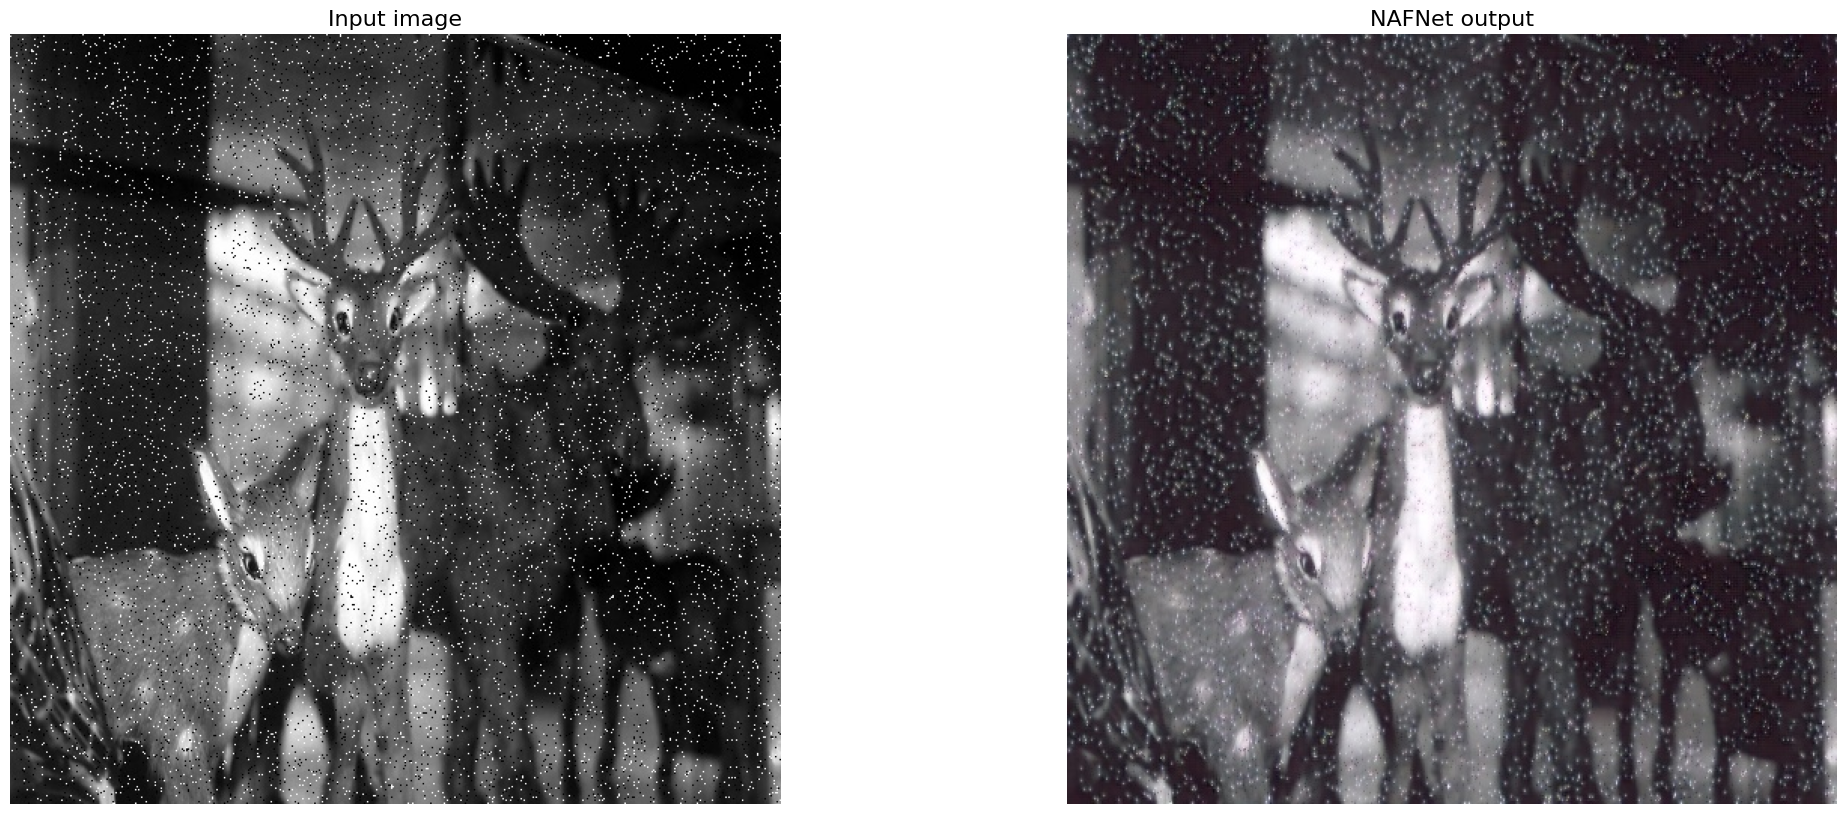

In [8]:
%cd ..
input_path = 'noisy/salt_pepper/noisy_3228569_786489110d_c.jpg'
output_path = 'denoisy/nafnet/salt_pepper/noisy_3228569_786489110d_c.jpg'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
display(img_input, img_output)

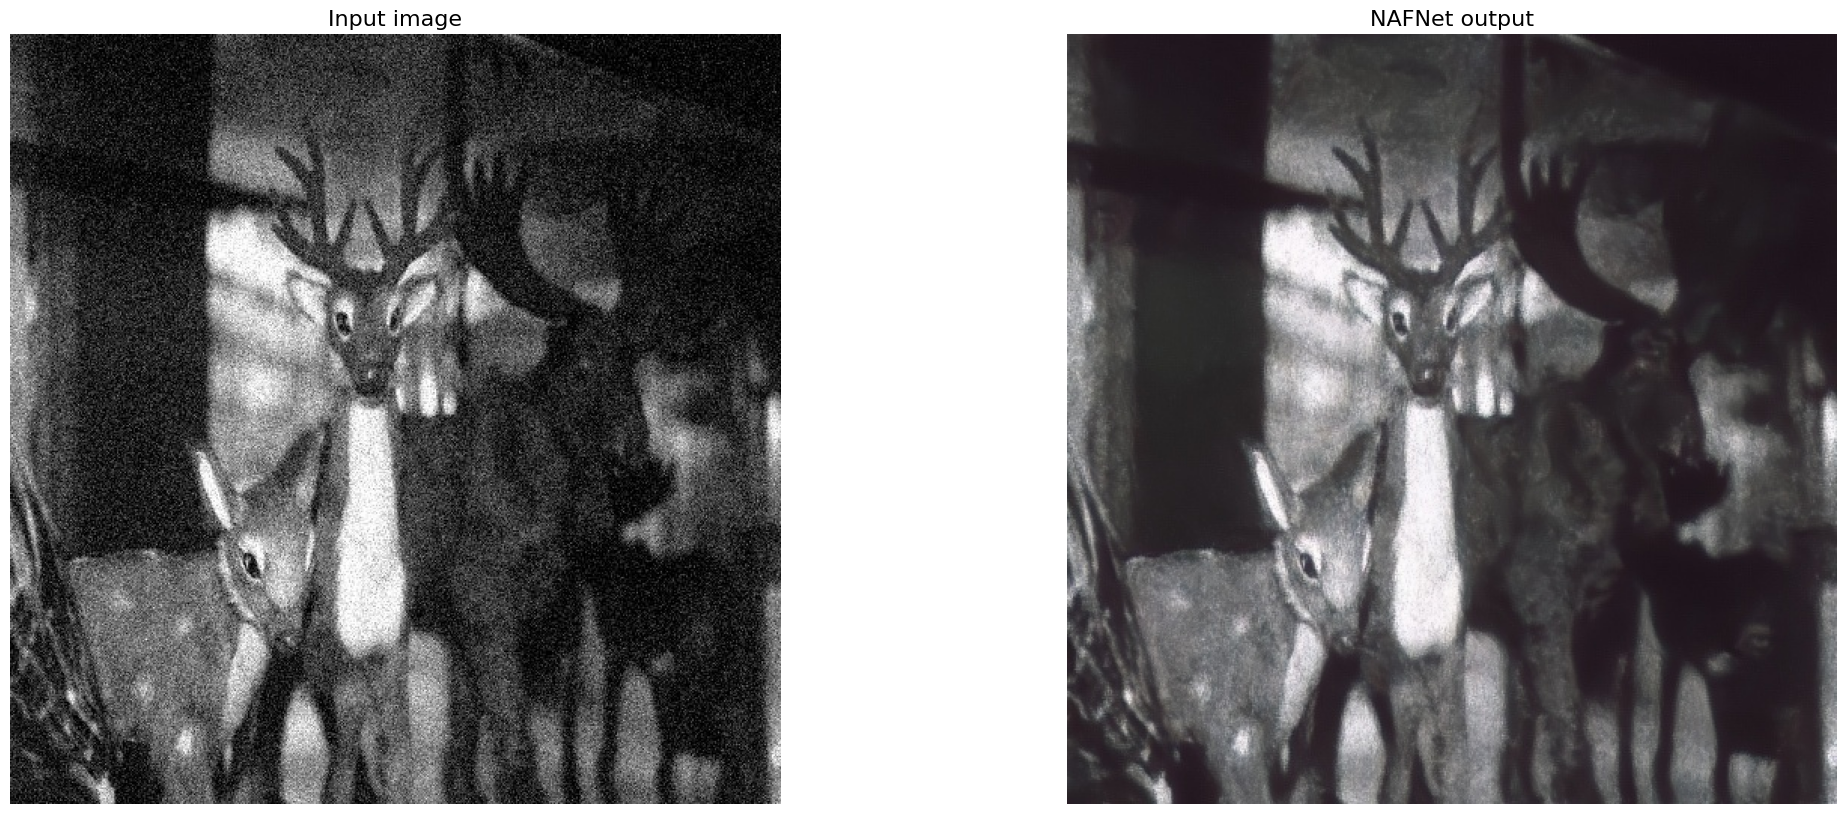

In [9]:
input_path = 'noisy/gaussian/noisy_3228569_786489110d_c.jpg'
output_path = 'denoisy/nafnet/gaussian/noisy_3228569_786489110d_c.jpg'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
display(img_input, img_output)

In [10]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(original, noisy, denoised):

    data_range = original.max() - original.min()

    psnr_noisy = psnr(original, noisy, data_range=data_range)
    ssim_noisy = ssim(original, noisy, data_range=data_range, multichannel=True)

    psnr_denoised = psnr(original, denoised, data_range=data_range)
    ssim_denoised = ssim(original, denoised, data_range=data_range, multichannel=True)

    return {
        'psnr_noisy': psnr_noisy,
        'ssim_noisy': ssim_noisy,
        'psnr_denoised': psnr_denoised,
        'ssim_denoised': ssim_denoised
    }


In [11]:
from skimage.color import rgb2gray

# Fonction pour traiter un dossier d'images
def process_images(noisy_folder, gt_folder, denoised_folder):
    # Crée le dossier de sortie s'il n'existe pas
    os.makedirs(denoised_folder, exist_ok=True)

    metrics = []

    # Liste des fichiers dans le dossier noisy
    noisy_images = [f for f in os.listdir(noisy_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_name in noisy_images:
        # Définir les chemins
        noisy_path = os.path.join(noisy_folder, image_name)
        gt_path = os.path.join(gt_folder, image_name.replace('noisy_', ''))  # Le nom du fichier original
        denoised_path = os.path.join(denoised_folder, image_name)

        # Vérifier si l'image originale existe
        if not os.path.exists(gt_path):
            print(f"L'image originale {image_name} est manquante dans le dossier gt.")
            continue

        # Charger l'image bruitée
        noisy_img = imread(noisy_path)

        # Appliquer NAFNet pour débruiter l'image
        img_input = img2tensor(noisy_img)
        single_image_inference(NAFNet, img_input, denoised_path)

        # Charger l'image débruitée
        denoised_img = imread(denoised_path)

        # Charger l'image originale
        gt_img = imread(gt_path)

        # Convertir l'image originale en noir et blanc
        if gt_img.ndim == 3:  # Si l'image est en couleur (3 canaux)
            gt_img = rgb2gray(gt_img)

        # S'assurer que toutes les images sont en noir et blanc
        if noisy_img.ndim == 3:  # Si l'image bruitée est en couleur
            noisy_img = rgb2gray(noisy_img)
        if denoised_img.ndim == 3:  # Si l'image débruitée est en couleur
            denoised_img = rgb2gray(denoised_img)

        # Calculer PSNR et SSIM entre l'image originale, bruitée et débruitée
        metrics_dict = calculate_metrics(gt_img, noisy_img, denoised_img)
        metrics_dict['image_name'] = image_name

        metrics.append(metrics_dict)

        # Si vous voulez vous amusuez à regarder le PSNR et SSIM pour chaque image
        # print(f"Image: {image_name}")
        # print(f"PSNR (Noisy vs Original): {metrics_dict['psnr_noisy']:.2f}, SSIM (Noisy vs Original): {metrics_dict['ssim_noisy']:.3f}")
        # print(f"PSNR (Denoised vs Original): {metrics_dict['psnr_denoised']:.2f}, SSIM (Denoised vs Original): {metrics_dict['ssim_denoised']:.3f}")
        # print("-" * 50)

    # Calculer les moyennes des scores
    avg_metrics = {
        'avg_psnr_noisy': np.mean([m['psnr_noisy'] for m in metrics]),
        'avg_ssim_noisy': np.mean([m['ssim_noisy'] for m in metrics]),
        'avg_psnr_denoised': np.mean([m['psnr_denoised'] for m in metrics]),
        'avg_ssim_denoised': np.mean([m['ssim_denoised'] for m in metrics]),
    }

    print("Moyenne des scores :")
    print(f"PSNR moyen (Noisy vs Original): {avg_metrics['avg_psnr_noisy']:.2f}")
    print(f"SSIM moyen (Noisy vs Original): {avg_metrics['avg_ssim_noisy']:.3f}")
    print(f"PSNR moyen (Denoised vs Original): {avg_metrics['avg_psnr_denoised']:.2f}")
    print(f"SSIM moyen (Denoised vs Original): {avg_metrics['avg_ssim_denoised']:.3f}")

    return metrics, avg_metrics

In [12]:
# Traitement d'image pour le bruit sel et poivre
noisy_folder = '/content/noisy/salt_pepper'
gt_folder = '/content/gt_v1'
denoised_folder = '/content/denoisy/nafnet/salt_pepper'

# Processus des images
metrics, avg_metrics = process_images(noisy_folder, gt_folder, denoised_folder)

Moyenne des scores :
PSNR moyen (Noisy vs Original): 17.59
SSIM moyen (Noisy vs Original): 0.370
PSNR moyen (Denoised vs Original): 19.42
SSIM moyen (Denoised vs Original): 0.448


In [13]:
# Traitement d'image pour le bruit gaussian
noisy_folder = '/content/noisy/gaussian'
gt_folder = '/content/gt_v1'
denoised_folder = '/content/denoisy/nafnet/gaussian'

# Processus des images
metrics, avg_metrics = process_images(noisy_folder, gt_folder, denoised_folder)

Moyenne des scores :
PSNR moyen (Noisy vs Original): 19.70
SSIM moyen (Noisy vs Original): 0.309
PSNR moyen (Denoised vs Original): 26.05
SSIM moyen (Denoised vs Original): 0.694
